In [ ]:
import requests
import nest_asyncio
import asyncio
from requests_html import AsyncHTMLSession
from bs4 import BeautifulSoup
from datetime import datetime
import random
import pandas as pd

station_codes = {
    "ADI": 0, "ADRA": 1, "AGRA": 2, "AII": 3, "APDJ": 4, "ASN": 5, "CSTM":6, "BCT": 7,
    "BKN": 8, "BPL": 9, "BRC": 10, "BSB": 11, "BSL": 12, "BSP": 13, "BVC": 14, "BZA": 15,
    "CKP": 16, "DDU": 17, "DHN": 18, "DLI": 19, "DNR": 20, "EDFC": 21, "FZR": 22, "GNT": 23,
    "GTL": 24, "HWH": 25, "HYB": 26, "IZN": 27, "JAT": 28, "JBP": 29, "JHS": 30, "JP": 31,
    "JU": 32, "KAWR": 33, "KGP": 34, "KIR": 35, "KOTA": 36, "KUR": 37, "LJN": 38, "LKO": 39,
    "LMG": 40, "MAS": 41, "MB": 42, "MDU": 43, "MLDT": 44, "MYS": 45, "NAG": 46, "NED": 47,
    "NEP": 48, "NGP": 49, "PGT": 50, "PRYJ": 51, "PUNE": 52, "R": 53, "RJT": 54, "RN": 55,
    "RNC": 56, "RNY": 57, "RTM": 58, "SA": 59, "SBC": 60, "SBP": 61, "SC": 62, "SDAH": 63,
    "SEE": 64, "SPJ": 65, "SUR": 66, "TPJ": 67, "TSK": 68, "TVC": 69, "UBL": 70,"WAT":71
}

def time_difference(time1, time2):
    format_24 = "%H.%M"
    t1 = datetime.strptime(time1, format_24)
    t2 = datetime.strptime(time2, format_24)

    diff = abs((t2 - t1).total_seconds()) // 60
    return int(diff)


def getPageNoFromEtrain(pageNo):

  url = f'https://etrain.info/list/GRB-TRAINS?page={pageNo}'
  response = requests.get(url)

  if (response.status_code==200):
    print("SuccessFully Fetched Website")
    soup=BeautifulSoup(response.content,'html.parser')

  else:
    print("Website Unavailable")

  table=soup.find_all('table',class_='DataTable RouteList')
  print(table)

  table=soup.find_all('table')
  tableRows=table[0].find_all('tr')
  ans=[]
  for rows in tableRows:
    anchors = rows.find_all('a')
    if (len(anchors)==2):
      trainNo=anchors[0].text
      trainName=anchors[1].text
      trainNameArray=trainName.split()
      trainNameArray=[elements.capitalize() for elements in trainNameArray]
      train=[]
      train.append("-".join(trainNameArray))
      train.append(trainNo)
      ans.append(train)

  return ans


def getTrainDelays(trainNo,trainName,timeline):

  url = f"https://etrain.info/train/{trainName}-{trainNo}/history?d={timeline}"
  response = requests.get(url)
  if (response.status_code == 200):
    soup = BeautifulSoup(response.text, 'html.parser')
  else:
    print ("Error getting the file")
    return []

  cnt=0;

  divs = soup.find_all('div', class_='inlineblock pdl5')
  for div in divs:
    delay_text = div.text.strip().replace("Avg. Delay:", "").replace("Min's", "").strip()
    cnt+=max(0,int(delay_text))

  return cnt/len(divs)


nest_asyncio.apply()

async def getTrainMetaDetails(trainNo):
    url = f"https://erail.in/train-enquiry/{trainNo}"

    USER_AGENTS = [
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36",
        "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
        "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.150 Safari/537.36",
        "Mozilla/5.0 (iPhone; CPU iPhone OS 14_0 like Mac OS X) AppleWebKit/537.36 (KHTML, like Gecko) Version/14.0 Mobile/15E148 Safari/537.36",
    ]

    headers = {
        "User-Agent": random.choice(USER_AGENTS),
        "Accept-Language": "en-US,en;q=0.9",
        "Connection": "keep-alive",
        "Referer": "https://www.google.com/",
        "DNT": "1",
        "Upgrade-Insecure-Requests": "1"
    }

    session = AsyncHTMLSession()

    try:
        response = await session.get(url, headers=headers)

        await response.html.arender(wait=random.uniform(2, 5), sleep=random.uniform(2, 5))

        soup = BeautifulSoup(response.html.html, "html.parser")
        tables = soup.find_all("table", class_="DataTable RouteList")


        arr = [0] * 72
        count, maxDistance, start = 0, 0, 0
        origin, destination, originZone, destinationZone = "", "", "", ""

        for row in tables[0].find_all("tr"):
            spans = row.find_all('span')
            title_text = spans[0]["title"]
            try:
              zone = title_text.split(",")[2].split("=")[1]
              print(title_text)
              arr[station_codes[zone]] += 1
            except Exception as e:
              print(e)
            count += 1
            data = row.find_all('td')
            maxDistance = int(data[9].text)

            if start == 0:
                start = 1
                origin = data[1].text
                originZone = title_text.split(",")[1].split("=")[1]
            else:
                destination = data[1].text
                destinationZone = title_text.split(",")[1].split("=")[1]


        trainType='GRB'

        res = [origin, destination, count, maxDistance, trainType, originZone, destinationZone]
        res.extend(arr)
        return res

    except Exception as e:
        print(f"Error occurred: {e}")
        print("Soup content:")
        print(soup if 'soup' in locals() else "Failed to parse page")
        return None



async def getAllTrainMeta():
    all_data = []
    error_count = 0

    for i in range(1,4):
        trains = getPageNoFromEtrain(i)

        for trainName, trainNo in trains:
            try:
                print(f"Processing train: {trainNo}")
                delayOneMonth = getTrainDelays(trainNo, trainName, "1m")
                res = await getTrainMetaDetails(trainNo)

                if res:
                    res.append(delayOneMonth)
                    all_data.append(res)
                    print(res)

                if len(all_data) % 20 == 0:
                    dump_to_csv(all_data)
                    all_data = []

            except Exception as e:
                print(f"Error occurred: {e}")
                error_count += 1

    if all_data:  # Save any remaining data
        dump_to_csv(all_data)

    print("CSV file saved successfully.")
    print("Total Number of errors =", error_count)

def dump_to_csv(data):
    headers = ["Origin", "Destination", "StopCount", "MaxDistance", "TrainType", "OriginZone", "DestinationZone"] + list(station_codes.keys()) + ["DelayOneMonth"]
    df = pd.DataFrame(data, columns=headers)
    df.to_csv("train_data.csv", mode='a', index=False, header=False)

async def getAllTrainMetaDetails():
    train_meta = await getAllTrainMeta()
    print(train_meta)

if __name__ == "__main__":
    asyncio.run(getAllTrainMetaDetails())

SuccessFully Fetched Website
[]
Processing train: 03309


ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=DHN, Zone=ECR, Division=DHN
Code=GMO, Zone=ECR, Division=DHN
Code=PNME, Zone=ECR, Division=DHN
Code=HZD, Zone=ECR, Division=DHN
Code=KQR, Zone=ECR, Division=DHN
Code=GAYA, Zone=ECR, Division=DDU
Code=AUBR, Zone=ECR, Division=DDU
Code=DOS, Zone=ECR, Division=DDU
Code=SSM, Zone=ECR, Division=DDU
Code=BBU, Zone=ECR, Division=DDU
Code=DDU, Zone=ECR, Division=DDU
Code=BSB, Zone=NR, Division=LKO
Code=PRYJ, Zone=NCR, Division=PRYJ
Code=CNB, Zone=NCR, Division=PRYJ
Code=GOY, Zone=NCR, Division=PRYJ
Code=TDL, Zone=NCR, Division=PRYJ
Code=DLI, Zone=NR, Division=DLI
Code=SNP, Zone=NR, Division=DLI
Code=PNP, Zone=NR, Division=DLI
Code=UMB, Zone=NR, Division=UMB
'UMB'
Code=SIR, Zone=NR, Division=UMB
'UMB'
Code=LDH, Zone=NR, Division=FZR
Code=JRC, Zone=NR, Division=FZR
Code=PTKC, Zone=NR, Division=FZR
Code=JAT, Zone=NR, Division=FZR
['DHN', 'JAT', 25, 1748, 'GRB', 'ECR', 'NR', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 5, 3, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=JAT, Zone=NR, Division=FZR
Code=PTKC, Zone=NR, Division=FZR
Code=JRC, Zone=NR, Division=FZR
Code=LDH, Zone=NR, Division=FZR
Code=SNL, Zone=NR, Division=FZR
Code=SIR, Zone=NR, Division=UMB
'UMB'
Code=UMB, Zone=NR, Division=UMB
'UMB'
Code=PNP, Zone=NR, Division=DLI
Code=SNP, Zone=NR, Division=DLI
Code=DLI, Zone=NR, Division=DLI
Code=GZB, Zone=NR, Division=DLI
Code=TDL, Zone=NCR, Division=PRYJ
Code=GOY, Zone=NCR, Division=PRYJ
Code=PRYJ, Zone=NCR, Division=PRYJ
Code=BSB, Zone=NR, Division=LKO
Code=DDU, Zone=ECR, Division=DDU
Code=BBU, Zone=ECR, Division=DDU
Code=SSM, Zone=ECR, Division=DDU
Code=DOS, Zone=ECR, Division=DDU
Code=AUBR, Zone=ECR, Division=DDU
Code=GAYA, Zone=ECR, Division=DDU
Code=KQR, Zone=ECR, Division=DHN
Code=HZD, Zone=ECR, Division=DHN
Code=PNME, Zone=ECR, Division=DHN
Code=GMO, Zone=ECR, Division=DHN
Code=DHN, Zone=ECR, Division=DHN
['JAT', 'DHN', 26, 1745, 'GRB', 'NR', 'ECR', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 5, 4, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0,

ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=SHC, Zone=ECR, Division=SPJ
Code=GEB, Zone=ECR, Division=SPJ
Code=SOU, Zone=ECR, Division=SPJ
Code=SRGR, Zone=ECR, Division=SPJ
Code=NMA, Zone=ECR, Division=SPJ
Code=GGH, Zone=ECR, Division=SPJ
Code=JJP, Zone=ECR, Division=SPJ
Code=SKI, Zone=ECR, Division=SPJ
Code=DBG, Zone=ECR, Division=SPJ
Code=JNR, Zone=ECR, Division=SPJ
Code=SMI, Zone=ECR, Division=SPJ
Code=BGU, Zone=ECR, Division=SPJ
Code=RXL, Zone=ECR, Division=SPJ
Code=NKE, Zone=ECR, Division=SPJ
Code=BUG, Zone=ECR, Division=SPJ
Code=PNYA, Zone=NE, Division=BSB
Code=CPJ, Zone=NE, Division=BSB
Code=GKP, Zone=NE, Division=LJN
Code=BST, Zone=NE, Division=LJN
Code=GD, Zone=NE, Division=LJN
Code=STP, Zone=NE, Division=LJN
Code=SPN, Zone=NR, Division=MB
Code=BE, Zone=NR, Division=MB
Code=MB, Zone=NR, Division=MB
Code=GZB, Zone=NR, Division=DLI
Code=ANVT, Zone=NR, Division=DLI
['SHC', 'ANVT', 26, 1201, 'GRB', 'ECR', 'NR', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=ANVT, Zone=NR, Division=DLI
Code=GZB, Zone=NR, Division=DLI
Code=MB, Zone=NR, Division=MB
Code=BE, Zone=NR, Division=MB
Code=SPN, Zone=NR, Division=MB
Code=STP, Zone=NE, Division=LJN
Code=GD, Zone=NE, Division=LJN
Code=BST, Zone=NE, Division=LJN
Code=GKP, Zone=NE, Division=LJN
Code=CPJ, Zone=NE, Division=BSB
Code=PNYA, Zone=NE, Division=BSB
Code=BUG, Zone=ECR, Division=SPJ
Code=NKE, Zone=ECR, Division=SPJ
Code=RXL, Zone=ECR, Division=SPJ
Code=BGU, Zone=ECR, Division=SPJ
Code=SMI, Zone=ECR, Division=SPJ
Code=JNR, Zone=ECR, Division=SPJ
Code=DBG, Zone=ECR, Division=SPJ
Code=SKI, Zone=ECR, Division=SPJ
Code=JJP, Zone=ECR, Division=SPJ
Code=GGH, Zone=ECR, Division=SPJ
Code=NMA, Zone=ECR, Division=SPJ
Code=SRGR, Zone=ECR, Division=SPJ
Code=SOU, Zone=ECR, Division=SPJ
Code=GEB, Zone=ECR, Division=SPJ
Code=SHC, Zone=ECR, Division=SPJ
['ANVT', 'SHC', 26, 1201, 'GRB', 'NR', 'ECR', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=SGAC, Zone=WCR, Division=KOTA
Code=BAZ, Zone=WCR, Division=KOTA
Code=RTA, Zone=WCR, Division=BPL
Code=GUNA, Zone=WCR, Division=BPL
Code=SGO, Zone=WCR, Division=JBP
Code=DMO, Zone=WCR, Division=JBP
Code=KMZ, Zone=WCR, Division=JBP
Code=MYR, Zone=WCR, Division=JBP
Code=STA, Zone=WCR, Division=JBP
Code=MKP, Zone=NCR, Division=JHS
Code=PCOI, Zone=NCR, Division=PRYJ
Code=BDL, Zone=NCR, Division=PRYJ
Code=DDU, Zone=ECR, Division=DDU
Code=BXR, Zone=ECR, Division=DNR
Code=ARA, Zone=ECR, Division=DNR
Code=DNR, Zone=ECR, Division=DNR
['SGAC', 'DNR', 16, 1174, 'GRB', 'WCR', 'ECR', 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 5, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 83.25]
Processing train: 09820


ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=DNR, Zone=ECR, Division=DNR
Code=ARA, Zone=ECR, Division=DNR
Code=BXR, Zone=ECR, Division=DNR
Code=DDU, Zone=ECR, Division=DDU
Code=BDL, Zone=NCR, Division=PRYJ
Code=PCOI, Zone=NCR, Division=PRYJ
Code=MKP, Zone=NCR, Division=JHS
Code=STA, Zone=WCR, Division=JBP
Code=MYR, Zone=WCR, Division=JBP
Code=KMZ, Zone=WCR, Division=JBP
Code=DMO, Zone=WCR, Division=JBP
Code=SGO, Zone=WCR, Division=JBP
Code=GUNA, Zone=WCR, Division=BPL
Code=RTA, Zone=WCR, Division=BPL
Code=BAZ, Zone=WCR, Division=KOTA
Code=SGAC, Zone=WCR, Division=KOTA
['DNR', 'SGAC', 16, 1175, 'GRB', 'ECR', 'WCR', 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 5, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 244.1875]
Processing train: 12113


ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=PUNE, Zone=CR, Division=PUNE
Code=DDCC, Zone=CR, Division=SUR
Code=ANG, Zone=CR, Division=SUR
Code=MMR, Zone=CR, Division=BSL
Code=BSL, Zone=CR, Division=BSL
Code=NN, Zone=CR, Division=BSL
Code=SEG, Zone=CR, Division=BSL
Code=AK, Zone=CR, Division=BSL
Code=BD, Zone=CR, Division=BSL
Code=DMN, Zone=CR, Division=NGP
Code=WR, Zone=CR, Division=NGP
Code=AJNI, Zone=CR, Division=NGP
Code=NGP, Zone=CR, Division=NGP
['PUNE', 'NGP', 13, 884, 'GRB', 'CR', 'CR', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 16.76923076923077]
Processing train: 12114


ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=NGP, Zone=CR, Division=NGP
Code=AJNI, Zone=CR, Division=NGP
Code=WR, Zone=CR, Division=NGP
Code=DMN, Zone=CR, Division=NGP
Code=BD, Zone=CR, Division=BSL
Code=AK, Zone=CR, Division=BSL
Code=SEG, Zone=CR, Division=BSL
Code=NN, Zone=CR, Division=BSL
Code=BSL, Zone=CR, Division=BSL
Code=MMR, Zone=CR, Division=BSL
Code=ANG, Zone=CR, Division=SUR
Code=DDCC, Zone=CR, Division=SUR
Code=PUNE, Zone=CR, Division=PUNE
['NGP', 'PUNE', 13, 884, 'GRB', 'CR', 'CR', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 12.076923076923077]
Processing train: 12187


ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=JBP, Zone=WCR, Division=JBP
Code=SRID, Zone=WCR, Division=JBP
Code=NU, Zone=WCR, Division=JBP
Code=GAR, Zone=WCR, Division=JBP
Code=PPI, Zone=WCR, Division=JBP
Code=ET, Zone=WCR, Division=BPL
Code=HD, Zone=WCR, Division=BPL
Code=KNW, Zone=CR, Division=BSL
Code=BSL, Zone=CR, Division=BSL
Code=JL, Zone=CR, Division=BSL
Code=MMR, Zone=CR, Division=BSL
Code=NK, Zone=CR, Division=BSL
Code=IGP, Zone=CR, Division=CSTM
Code=KYN, Zone=CR, Division=CSTM
Code=DR, Zone=CR, Division=CSTM
Code=CSMT, Zone=CR, Division=CSTM
['JBP', 'CSMT', 16, 996, 'GRB', 'WCR', 'CR', 0, 0, 0, 0, 0, 0, 4, 0, 0, 2, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 14.333333333333334]
Processing train: 12188


ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=CSMT, Zone=CR, Division=CSTM
Code=DR, Zone=CR, Division=CSTM
Code=KYN, Zone=CR, Division=CSTM
Code=IGP, Zone=CR, Division=CSTM
Code=NK, Zone=CR, Division=BSL
Code=MMR, Zone=CR, Division=BSL
Code=JL, Zone=CR, Division=BSL
Code=BSL, Zone=CR, Division=BSL
Code=KNW, Zone=CR, Division=BSL
Code=HD, Zone=WCR, Division=BPL
Code=ET, Zone=WCR, Division=BPL
Code=PPI, Zone=WCR, Division=JBP
Code=GAR, Zone=WCR, Division=JBP
Code=NU, Zone=WCR, Division=JBP
Code=SRID, Zone=WCR, Division=JBP
Code=JBP, Zone=WCR, Division=JBP
['CSMT', 'JBP', 16, 996, 'GRB', 'CR', 'WCR', 0, 0, 0, 0, 0, 0, 4, 0, 0, 2, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 33.2]
Processing train: 12201


ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=LTT, Zone=CR, Division=CSTM
Code=TNA, Zone=CR, Division=CSTM
Code=DIVA, Zone=CR, Division=CSTM
Code=PNVL, Zone=CR, Division=CSTM
Code=RN, Zone=KRCL, Division=RN
Code=MAO, Zone=KRCL, Division=KAWR
Code=KAWR, Zone=KRCL, Division=KAWR
Code=ANKL, Zone=KRCL, Division=KAWR
Code=BYNR, Zone=KRCL, Division=KAWR
Code=UD, Zone=KRCL, Division=KAWR
Code=MAJN, Zone=SR, Division=PGT
Code=KGQ, Zone=SR, Division=PGT
Code=KZE, Zone=SR, Division=PGT
Code=CAN, Zone=SR, Division=PGT
Code=CLT, Zone=SR, Division=PGT
Code=TIR, Zone=SR, Division=PGT
Code=SRR, Zone=SR, Division=PGT
Code=TCR, Zone=SR, Division=TVC
Code=ERN, Zone=SR, Division=TVC
Code=KTYM, Zone=SR, Division=TVC
Code=CGY, Zone=SR, Division=TVC
Code=TRVL, Zone=SR, Division=TVC
Code=CNGR, Zone=SR, Division=TVC
Code=KYJ, Zone=SR, Division=TVC
Code=QLN, Zone=SR, Division=TVC
Code=KCVL, Zone=SR, Division=TVC
['LTT', 'KCVL', 26, 1812, 'GRB', 'CR', 'SR', 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=KCVL, Zone=SR, Division=TVC
Code=QLN, Zone=SR, Division=TVC
Code=KYJ, Zone=SR, Division=TVC
Code=CNGR, Zone=SR, Division=TVC
Code=TRVL, Zone=SR, Division=TVC
Code=CGY, Zone=SR, Division=TVC
Code=KTYM, Zone=SR, Division=TVC
Code=ERN, Zone=SR, Division=TVC
Code=TCR, Zone=SR, Division=TVC
Code=SRR, Zone=SR, Division=PGT
Code=TIR, Zone=SR, Division=PGT
Code=CLT, Zone=SR, Division=PGT
Code=CAN, Zone=SR, Division=PGT
Code=KGQ, Zone=SR, Division=PGT
Code=MAJN, Zone=SR, Division=PGT
Code=UD, Zone=KRCL, Division=KAWR
Code=BYNR, Zone=KRCL, Division=KAWR
Code=ANKL, Zone=KRCL, Division=KAWR
Code=KAWR, Zone=KRCL, Division=KAWR
Code=MAO, Zone=KRCL, Division=KAWR
Code=RN, Zone=KRCL, Division=RN
Code=PNVL, Zone=CR, Division=CSTM
Code=TNA, Zone=CR, Division=CSTM
Code=LTT, Zone=CR, Division=CSTM
['KCVL', 'LTT', 24, 1812, 'GRB', 'SR', 'CR', 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0,

ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=SHC, Zone=ECR, Division=SPJ
Code=SBV, Zone=ECR, Division=SPJ
Code=KGG, Zone=ECR, Division=SEE
Code=BGS, Zone=ECR, Division=SEE
Code=BJU, Zone=ECR, Division=SEE
Code=DSS, Zone=ECR, Division=SEE
Code=SPJ, Zone=ECR, Division=SPJ
Code=MFP, Zone=ECR, Division=SEE
Code=HJP, Zone=ECR, Division=SEE
Code=CPR, Zone=NE, Division=BSB
Code=SV, Zone=NE, Division=BSB
Code=DEOS, Zone=NE, Division=BSB
Code=GKP, Zone=NE, Division=LJN
Code=BNZ, Zone=NE, Division=LJN
Code=LKO, Zone=NR, Division=LKO
Code=HRI, Zone=NR, Division=MB
Code=BE, Zone=NR, Division=MB
Code=MB, Zone=NR, Division=MB
Code=HPU, Zone=NR, Division=MB
Code=TKJ, Zone=NR, Division=DLI
Code=NDLS, Zone=NR, Division=DLI
Code=DLI, Zone=NR, Division=DLI
Code=UMB, Zone=NR, Division=UMB
'UMB'
Code=SIR, Zone=NR, Division=UMB
'UMB'
Code=LDH, Zone=NR, Division=FZR
Code=PGW, Zone=NR, Division=FZR
Code=JUC, Zone=NR, Division=FZR
Code=BEAS, Zone=NR, Division=FZR
Code=ASR, Zone=NR, Division=FZR
['SHC', 'ASR', 29, 1722, 'GRB', 'ECR', 'NR', 0, 0, 0, 0

ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=ASR, Zone=NR, Division=FZR
Code=BEAS, Zone=NR, Division=FZR
Code=JUC, Zone=NR, Division=FZR
Code=PGW, Zone=NR, Division=FZR
Code=LDH, Zone=NR, Division=FZR
Code=DDL, Zone=NR, Division=FZR
Code=SIR, Zone=NR, Division=UMB
'UMB'
Code=UMB, Zone=NR, Division=UMB
'UMB'
Code=DLI, Zone=NR, Division=DLI
Code=NDLS, Zone=NR, Division=DLI
Code=TKJ, Zone=NR, Division=DLI
Code=HPU, Zone=NR, Division=MB
Code=MB, Zone=NR, Division=MB
Code=BE, Zone=NR, Division=MB
Code=HRI, Zone=NR, Division=MB
Code=LKO, Zone=NR, Division=LKO
Code=BNZ, Zone=NE, Division=LJN
Code=GKP, Zone=NE, Division=LJN
Code=DEOS, Zone=NE, Division=BSB
Code=SV, Zone=NE, Division=BSB
Code=CPR, Zone=NE, Division=BSB
Code=HJP, Zone=ECR, Division=SEE
Code=MFP, Zone=ECR, Division=SEE
Code=SPJ, Zone=ECR, Division=SPJ
Code=DSS, Zone=ECR, Division=SEE
Code=BJU, Zone=ECR, Division=SEE
Code=BGS, Zone=ECR, Division=SEE
Code=KGG, Zone=ECR, Division=SEE
Code=SBV, Zone=ECR, Division=SPJ
Code=SHC, Zone=ECR, Division=SPJ
['ASR', 'SHC', 30, 1722

ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=KGM, Zone=NE, Division=IZN
Code=HDW, Zone=NE, Division=IZN
Code=LKU, Zone=NE, Division=IZN
Code=RUPC, Zone=NE, Division=IZN
Code=BLQR, Zone=NE, Division=IZN
Code=RMU, Zone=NR, Division=MB
Code=MB, Zone=NR, Division=MB
Code=LRJ, Zone=NR, Division=MB
Code=SRE, Zone=NR, Division=UMB
'UMB'
Code=YJUD, Zone=NR, Division=UMB
'UMB'
Code=UMB, Zone=NR, Division=UMB
'UMB'
Code=LDH, Zone=NR, Division=FZR
Code=JRC, Zone=NR, Division=FZR
Code=PTKC, Zone=NR, Division=FZR
Code=JAT, Zone=NR, Division=FZR
['KGM', 'JAT', 15, 768, 'GRB', 'NE', 'NR', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0]
Processing train: 12208


ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=JAT, Zone=NR, Division=FZR
Code=KTHU, Zone=NR, Division=FZR
Code=PTKC, Zone=NR, Division=FZR
Code=JRC, Zone=NR, Division=FZR
Code=LDH, Zone=NR, Division=FZR
Code=UMB, Zone=NR, Division=UMB
'UMB'
Code=YJUD, Zone=NR, Division=UMB
'UMB'
Code=SRE, Zone=NR, Division=UMB
'UMB'
Code=LRJ, Zone=NR, Division=MB
Code=MB, Zone=NR, Division=MB
Code=RMU, Zone=NR, Division=MB
Code=BLQR, Zone=NE, Division=IZN
Code=RUPC, Zone=NE, Division=IZN
Code=LKU, Zone=NE, Division=IZN
Code=HDW, Zone=NE, Division=IZN
Code=KGM, Zone=NE, Division=IZN
['JAT', 'KGM', 16, 768, 'GRB', 'NR', 'NE', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0]
Processing train: 12209


ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=CNB, Zone=NCR, Division=PRYJ
Code=LJN, Zone=NE, Division=LJN
Code=SPN, Zone=NR, Division=MB
Code=BE, Zone=NR, Division=MB
Code=RMU, Zone=NR, Division=MB
Code=BLQR, Zone=NE, Division=IZN
Code=RUPC, Zone=NE, Division=IZN
Code=LKU, Zone=NE, Division=IZN
Code=HDW, Zone=NE, Division=IZN
Code=KGM, Zone=NE, Division=IZN
['CNB', 'KGM', 10, 461, 'GRB', 'NCR', 'NE', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0]
Processing train: 12210


ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=KGM, Zone=NE, Division=IZN
Code=HDW, Zone=NE, Division=IZN
Code=LKU, Zone=NE, Division=IZN
Code=RUPC, Zone=NE, Division=IZN
Code=BLQR, Zone=NE, Division=IZN
Code=RMU, Zone=NR, Division=MB
Code=BE, Zone=NR, Division=MB
Code=SPN, Zone=NR, Division=MB
Code=LJN, Zone=NE, Division=LJN
Code=CNB, Zone=NCR, Division=PRYJ
['KGM', 'CNB', 10, 461, 'GRB', 'NE', 'NCR', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0]
Processing train: 12211


ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=MFP, Zone=ECR, Division=SEE
Code=CAA, Zone=ECR, Division=SPJ
Code=BMKI, Zone=ECR, Division=SPJ
Code=SGL, Zone=ECR, Division=SPJ
Code=BTH, Zone=ECR, Division=SPJ
Code=NKE, Zone=ECR, Division=SPJ
Code=BUG, Zone=ECR, Division=SPJ
Code=GKP, Zone=NE, Division=LJN
Code=GD, Zone=NE, Division=LJN
Code=LKO, Zone=NR, Division=LKO
Code=SPN, Zone=NR, Division=MB
Code=BE, Zone=NR, Division=MB
Code=MB, Zone=NR, Division=MB
Code=ANVT, Zone=NR, Division=DLI
['MFP', 'ANVT', 14, 1059, 'GRB', 'ECR', 'NR', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 6, 0, 0, 0, 0, 0, 0, 28.214285714285715]
Processing train: 12212


ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=ANVT, Zone=NR, Division=DLI
Code=MB, Zone=NR, Division=MB
Code=BE, Zone=NR, Division=MB
Code=SPN, Zone=NR, Division=MB
Code=LKO, Zone=NR, Division=LKO
Code=GD, Zone=NE, Division=LJN
Code=BST, Zone=NE, Division=LJN
Code=GKP, Zone=NE, Division=LJN
Code=BUG, Zone=ECR, Division=SPJ
Code=NKE, Zone=ECR, Division=SPJ
Code=BTH, Zone=ECR, Division=SPJ
Code=SGL, Zone=ECR, Division=SPJ
Code=BMKI, Zone=ECR, Division=SPJ
Code=CAA, Zone=ECR, Division=SPJ
Code=MFP, Zone=ECR, Division=SEE
['ANVT', 'MFP', 15, 1059, 'GRB', 'NR', 'ECR', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 6, 0, 0, 0, 0, 0, 0, 160.92857142857142]
Processing train: 12215


ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=DEE, Zone=NR, Division=DLI
Code=DEC, Zone=NR, Division=DLI
Code=GGN, Zone=NR, Division=DLI
Code=RE, Zone=NWR, Division=JP
Code=KRH, Zone=NWR, Division=JP
Code=AWR, Zone=NWR, Division=JP
Code=JP, Zone=NWR, Division=JP
Code=AII, Zone=NWR, Division=AII
Code=FA, Zone=NWR, Division=AII
Code=ABR, Zone=NWR, Division=AII
Code=PNU, Zone=WR, Division=ADI
Code=GNC, Zone=WR, Division=ADI
Code=ADI, Zone=WR, Division=ADI
Code=ND, Zone=WR, Division=BRC
Code=ANND, Zone=WR, Division=BRC
Code=BRC, Zone=WR, Division=BRC
Code=BH, Zone=WR, Division=BRC
Code=ST, Zone=WR, Division=BCT
Code=UDN, Zone=WR, Division=BCT
Code=BVI, Zone=WR, Division=BCT
Code=BDTS, Zone=WR, Division=BCT
['DEE', 'BDTS', 21, 1431, 'GRB', 'NR', 'WR', 3, 0, 0, 3, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5.857142857142857]
Processing train: 12216


ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=BDTS, Zone=WR, Division=BCT
Code=BVI, Zone=WR, Division=BCT
Code=ST, Zone=WR, Division=BCT
Code=BH, Zone=WR, Division=BRC
Code=BRC, Zone=WR, Division=BRC
Code=ANND, Zone=WR, Division=BRC
Code=ND, Zone=WR, Division=BRC
Code=ADI, Zone=WR, Division=ADI
Code=GNC, Zone=WR, Division=ADI
Code=PNU, Zone=WR, Division=ADI
Code=ABR, Zone=NWR, Division=AII
Code=FA, Zone=NWR, Division=AII
Code=AII, Zone=NWR, Division=AII
Code=JP, Zone=NWR, Division=JP
Code=AWR, Zone=NWR, Division=JP
Code=KRH, Zone=NWR, Division=JP
Code=RE, Zone=NWR, Division=JP
Code=GGN, Zone=NR, Division=DLI
Code=DEC, Zone=NR, Division=DLI
Code=DEE, Zone=NR, Division=DLI
['BDTS', 'DEE', 20, 1432, 'GRB', 'WR', 'NR', 3, 0, 0, 3, 0, 0, 0, 3, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12.55]
Processing train: 12257


ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=YPR, Zone=SWR, Division=SBC
Code=BAND, Zone=SWR, Division=SBC
Code=HSRA, Zone=SWR, Division=SBC
Code=DPJ, Zone=SWR, Division=SBC
Code=SA, Zone=SR, Division=SA
Code=ED, Zone=SR, Division=SA
Code=CBF, Zone=SR, Division=SA
Code=CBE, Zone=SR, Division=SA
Code=PGT, Zone=SR, Division=PGT
Code=TCR, Zone=SR, Division=TVC
Code=AWY, Zone=SR, Division=TVC
Code=ERN, Zone=SR, Division=TVC
Code=KTYM, Zone=SR, Division=TVC
Code=CGY, Zone=SR, Division=TVC
Code=TRVL, Zone=SR, Division=TVC
Code=CNGR, Zone=SR, Division=TVC
Code=MVLK, Zone=SR, Division=TVC
Code=KYJ, Zone=SR, Division=TVC
Code=QLN, Zone=SR, Division=TVC
Code=KCVL, Zone=SR, Division=TVC
['YPR', 'KCVL', 20, 807, 'GRB', 'SWR', 'SR', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 11, 0, 0, 17.473684210526315]
Processing train: 12258


ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=KCVL, Zone=SR, Division=TVC
Code=QLN, Zone=SR, Division=TVC
Code=KYJ, Zone=SR, Division=TVC
Code=MVLK, Zone=SR, Division=TVC
Code=CNGR, Zone=SR, Division=TVC
Code=TRVL, Zone=SR, Division=TVC
Code=CGY, Zone=SR, Division=TVC
Code=KTYM, Zone=SR, Division=TVC
Code=ERN, Zone=SR, Division=TVC
Code=AWY, Zone=SR, Division=TVC
Code=TCR, Zone=SR, Division=TVC
Code=PGT, Zone=SR, Division=PGT
Code=CBE, Zone=SR, Division=SA
Code=CBF, Zone=SR, Division=SA
Code=ED, Zone=SR, Division=SA
Code=SA, Zone=SR, Division=SA
Code=DPJ, Zone=SWR, Division=SBC
Code=HSRA, Zone=SWR, Division=SBC
Code=BAND, Zone=SWR, Division=SBC
Code=YPR, Zone=SWR, Division=SBC
['KCVL', 'YPR', 20, 807, 'GRB', 'SR', 'SWR', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 11, 0, 0, 22.68421052631579]
Processing train: 12359


ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=KOAA, Zone=ER, Division=SDAH
Code=DGR, Zone=ER, Division=ASN
Code=ASN, Zone=ER, Division=ASN
Code=MDP, Zone=ER, Division=ASN
Code=JSME, Zone=ER, Division=ASN
Code=JAJ, Zone=ECR, Division=DNR
Code=JMU, Zone=ECR, Division=DNR
Code=KIUL, Zone=ECR, Division=DNR
Code=MKA, Zone=ECR, Division=DNR
Code=BKP, Zone=ECR, Division=DNR
Code=PNC, Zone=ECR, Division=DNR
Code=RJPB, Zone=ECR, Division=DNR
Code=PNBE, Zone=ECR, Division=DNR
['KOAA', 'PNBE', 13, 534, 'GRB', 'ER', 'ECR', 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 30.692307692307693]
SuccessFully Fetched Website
[]
Processing train: 12360


ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=PNBE, Zone=ECR, Division=DNR
Code=RJPB, Zone=ECR, Division=DNR
Code=PNC, Zone=ECR, Division=DNR
Code=BKP, Zone=ECR, Division=DNR
Code=MKA, Zone=ECR, Division=DNR
Code=KIUL, Zone=ECR, Division=DNR
Code=JMU, Zone=ECR, Division=DNR
Code=JAJ, Zone=ECR, Division=DNR
Code=JSME, Zone=ER, Division=ASN
Code=MDP, Zone=ER, Division=ASN
Code=ASN, Zone=ER, Division=ASN
Code=DGR, Zone=ER, Division=ASN
Code=KOAA, Zone=ER, Division=SDAH
['PNBE', 'KOAA', 13, 534, 'GRB', 'ECR', 'ER', 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 13.153846153846153]
Processing train: 12435


ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=JYG, Zone=ECR, Division=SPJ
Code=MBI, Zone=ECR, Division=SPJ
Code=SKI, Zone=ECR, Division=SPJ
Code=DBG, Zone=ECR, Division=SPJ
Code=LSI, Zone=ECR, Division=SPJ
Code=HYT, Zone=ECR, Division=SPJ
Code=SPJ, Zone=ECR, Division=SPJ
Code=BJU, Zone=ECR, Division=SEE
Code=MKA, Zone=ECR, Division=DNR
Code=BKP, Zone=ECR, Division=DNR
Code=PNC, Zone=ECR, Division=DNR
Code=PNBE, Zone=ECR, Division=DNR
Code=DNR, Zone=ECR, Division=DNR
Code=ARA, Zone=ECR, Division=DNR
Code=BEA, Zone=ECR, Division=DNR
Code=DURE, Zone=ECR, Division=DNR
Code=BXR, Zone=ECR, Division=DNR
Code=DDU, Zone=ECR, Division=DDU
Code=MZP, Zone=NCR, Division=PRYJ
Code=PRYJ, Zone=NCR, Division=PRYJ
Code=CNB, Zone=NCR, Division=PRYJ
Code=ALJN, Zone=NCR, Division=PRYJ
Code=ANVT, Zone=NR, Division=DLI
['JYG', 'ANVT', 23, 1251, 'GRB', 'ECR', 'NR', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=ANVT, Zone=NR, Division=DLI
Code=ALJN, Zone=NCR, Division=PRYJ
Code=CNB, Zone=NCR, Division=PRYJ
Code=PRYJ, Zone=NCR, Division=PRYJ
Code=MZP, Zone=NCR, Division=PRYJ
Code=DDU, Zone=ECR, Division=DDU
Code=BXR, Zone=ECR, Division=DNR
Code=DURE, Zone=ECR, Division=DNR
Code=BEA, Zone=ECR, Division=DNR
Code=ARA, Zone=ECR, Division=DNR
Code=DNR, Zone=ECR, Division=DNR
Code=PNBE, Zone=ECR, Division=DNR
Code=PNC, Zone=ECR, Division=DNR
Code=BKP, Zone=ECR, Division=DNR
Code=MKA, Zone=ECR, Division=DNR
Code=BJU, Zone=ECR, Division=SEE
Code=SPJ, Zone=ECR, Division=SPJ
Code=HYT, Zone=ECR, Division=SPJ
Code=LSI, Zone=ECR, Division=SPJ
Code=DBG, Zone=ECR, Division=SPJ
Code=SKI, Zone=ECR, Division=SPJ
Code=MBI, Zone=ECR, Division=SPJ
Code=JYG, Zone=ECR, Division=SPJ
['ANVT', 'JYG', 23, 1253, 'GRB', 'NR', 'ECR', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=KOAA, Zone=ER, Division=SDAH
Code=BDC, Zone=ER, Division=HWH
Code=NDAE, Zone=ER, Division=HWH
Code=KWAE, Zone=ER, Division=HWH
Code=AZ, Zone=ER, Division=HWH
Code=JRLE, Zone=ER, Division=MLDT
Code=MLDT, Zone=ER, Division=MLDT
Code=KNE, Zone=NFR, Division=KIR
Code=NJP, Zone=NFR, Division=KIR
Code=NCB, Zone=NFR, Division=APDJ
Code=NOQ, Zone=NFR, Division=APDJ
Code=KOJ, Zone=NFR, Division=APDJ
Code=NBQ, Zone=NFR, Division=RNY
Code=GLPT, Zone=NFR, Division=RNY
Code=GHY, Zone=NFR, Division=LMG
Code=MYD, Zone=NFR, Division=LMG
Code=NHLG, Zone=NFR, Division=LMG
Code=BPB, Zone=NFR, Division=LMG
Code=NKMG, Zone=NFR, Division=LMG
Code=DMR, Zone=NFR, Division=LMG
Code=AGTL, Zone=NFR, Division=LMG
['KOAA', 'AGTL', 21, 1587, 'GRB', 'ER', 'NFR', 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 7, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 51.23809523809524]
Processing train: 

ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=AGTL, Zone=NFR, Division=LMG
Code=DMR, Zone=NFR, Division=LMG
Code=NKMG, Zone=NFR, Division=LMG
Code=BPB, Zone=NFR, Division=LMG
Code=NHLG, Zone=NFR, Division=LMG
Code=MYD, Zone=NFR, Division=LMG
Code=GHY, Zone=NFR, Division=LMG
Code=GLPT, Zone=NFR, Division=RNY
Code=NBQ, Zone=NFR, Division=RNY
Code=KOJ, Zone=NFR, Division=APDJ
Code=NOQ, Zone=NFR, Division=APDJ
Code=NCB, Zone=NFR, Division=APDJ
Code=NJP, Zone=NFR, Division=KIR
Code=KNE, Zone=NFR, Division=KIR
Code=MLDT, Zone=ER, Division=MLDT
Code=JRLE, Zone=ER, Division=MLDT
Code=AZ, Zone=ER, Division=HWH
Code=KWAE, Zone=ER, Division=HWH
Code=NDAE, Zone=ER, Division=HWH
Code=BDC, Zone=ER, Division=HWH
Code=KOAA, Zone=ER, Division=SDAH
['AGTL', 'KOAA', 21, 1587, 'GRB', 'NFR', 'ER', 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 7, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 42.19047619047619]
Processing train: 

ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=KOAA, Zone=ER, Division=SDAH
Code=BDC, Zone=ER, Division=HWH
Code=NDAE, Zone=ER, Division=HWH
Code=KWAE, Zone=ER, Division=HWH
Code=AZ, Zone=ER, Division=HWH
Code=JRLE, Zone=ER, Division=MLDT
Code=MLDT, Zone=ER, Division=MLDT
Code=KNE, Zone=NFR, Division=KIR
Code=NJP, Zone=NFR, Division=KIR
Code=NCB, Zone=NFR, Division=APDJ
Code=NOQ, Zone=NFR, Division=APDJ
Code=KOJ, Zone=NFR, Division=APDJ
Code=NBQ, Zone=NFR, Division=RNY
Code=GLPT, Zone=NFR, Division=RNY
Code=GHY, Zone=NFR, Division=LMG
['KOAA', 'GHY', 15, 1027, 'GRB', 'ER', 'NFR', 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 43.6]
Processing train: 12518


ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=GHY, Zone=NFR, Division=LMG
Code=GLPT, Zone=NFR, Division=RNY
Code=NBQ, Zone=NFR, Division=RNY
Code=KOJ, Zone=NFR, Division=APDJ
Code=NOQ, Zone=NFR, Division=APDJ
Code=NCB, Zone=NFR, Division=APDJ
Code=NJP, Zone=NFR, Division=KIR
Code=KNE, Zone=NFR, Division=KIR
Code=MLDT, Zone=ER, Division=MLDT
Code=JRLE, Zone=ER, Division=MLDT
Code=AZ, Zone=ER, Division=HWH
Code=KWAE, Zone=ER, Division=HWH
Code=NDAE, Zone=ER, Division=HWH
Code=BDC, Zone=ER, Division=HWH
Code=KOAA, Zone=ER, Division=SDAH
['GHY', 'KOAA', 15, 1027, 'GRB', 'NFR', 'ER', 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 69.4]
Processing train: 12535


ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=LJN, Zone=NE, Division=LJN
Code=CNB, Zone=NCR, Division=PRYJ
Code=RGU, Zone=NCR, Division=JHS
Code=BNDA, Zone=NCR, Division=JHS
Code=ATE, Zone=NCR, Division=JHS
Code=CKTD, Zone=NCR, Division=JHS
Code=MKP, Zone=NCR, Division=JHS
Code=STA, Zone=WCR, Division=JBP
Code=MYR, Zone=WCR, Division=JBP
Code=KTE, Zone=WCR, Division=JBP
Code=SDL, Zone=SECR, Division=BSP
Code=APR, Zone=SECR, Division=BSP
Code=PND, Zone=SECR, Division=BSP
Code=USL, Zone=SECR, Division=BSP
Code=BYT, Zone=SECR, Division=R
Code=R, Zone=SECR, Division=R
['LJN', 'R', 16, 920, 'GRB', 'NE', 'SECR', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 5, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 62.0]
Processing train: 12536


ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=R, Zone=SECR, Division=R
Code=BYT, Zone=SECR, Division=R
Code=USL, Zone=SECR, Division=BSP
Code=PND, Zone=SECR, Division=BSP
Code=APR, Zone=SECR, Division=BSP
Code=SDL, Zone=SECR, Division=BSP
Code=KTE, Zone=WCR, Division=JBP
Code=MYR, Zone=WCR, Division=JBP
Code=STA, Zone=WCR, Division=JBP
Code=MKP, Zone=NCR, Division=JHS
Code=CKTD, Zone=NCR, Division=JHS
Code=ATE, Zone=NCR, Division=JHS
Code=BNDA, Zone=NCR, Division=JHS
Code=RGU, Zone=NCR, Division=JHS
Code=CNB, Zone=NCR, Division=PRYJ
Code=LJN, Zone=NE, Division=LJN
['R', 'LJN', 16, 922, 'GRB', 'SECR', 'NE', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 5, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 100.42857142857143]
Processing train: 12593


ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=LJN, Zone=NE, Division=LJN
Code=CNB, Zone=NCR, Division=PRYJ
Code=ORAI, Zone=NCR, Division=JHS
Code=VGLJ, Zone=NCR, Division=JHS
Code=BINA, Zone=WCR, Division=BPL
Code=BHS, Zone=WCR, Division=BPL
Code=BPL, Zone=WCR, Division=BPL
['LJN', 'BPL', 7, 586, 'GRB', 'NE', 'WCR', 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 29.285714285714285]
Processing train: 12594


ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=BPL, Zone=WCR, Division=BPL
Code=BHS, Zone=WCR, Division=BPL
Code=BINA, Zone=WCR, Division=BPL
Code=VGLJ, Zone=NCR, Division=JHS
Code=ORAI, Zone=NCR, Division=JHS
Code=CNB, Zone=NCR, Division=PRYJ
Code=LJN, Zone=NE, Division=LJN
['BPL', 'LJN', 7, 586, 'GRB', 'WCR', 'NE', 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 24.714285714285715]
Processing train: 12611


ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=MAS, Zone=SR, Division=MAS
Code=GDR, Zone=SCR, Division=BZA
Code=OGL, Zone=SCR, Division=BZA
Code=BZA, Zone=SCR, Division=BZA
Code=WL, Zone=SCR, Division=SC
Code=BPQ, Zone=CR, Division=NGP
Code=NGP, Zone=CR, Division=NGP
Code=BPL, Zone=WCR, Division=BPL
Code=VGLJ, Zone=NCR, Division=JHS
Code=GWL, Zone=NCR, Division=JHS
Code=AGC, Zone=NCR, Division=AGRA
Code=NZM, Zone=NR, Division=DLI
['MAS', 'NZM', 12, 2180, 'GRB', 'SR', 'NR', 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 22.833333333333332]
Processing train: 12612


ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=NZM, Zone=NR, Division=DLI
Code=AGC, Zone=NCR, Division=AGRA
Code=GWL, Zone=NCR, Division=JHS
Code=VGLJ, Zone=NCR, Division=JHS
Code=BPL, Zone=WCR, Division=BPL
Code=NGP, Zone=CR, Division=NGP
Code=BPQ, Zone=CR, Division=NGP
Code=WL, Zone=SCR, Division=SC
Code=BZA, Zone=SCR, Division=BZA
Code=OGL, Zone=SCR, Division=BZA
Code=GDR, Zone=SCR, Division=BZA
Code=MAS, Zone=SR, Division=MAS
['NZM', 'MAS', 12, 2176, 'GRB', 'NR', 'SR', 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 44.166666666666664]
Processing train: 12735


ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=SC, Zone=SCR, Division=SC
Code=BMT, Zone=SCR, Division=SC
Code=LPI, Zone=SCR, Division=SC
Code=CT, Zone=SCR, Division=SC
Code=YG, Zone=SCR, Division=GTL
Code=RC, Zone=SCR, Division=GTL
Code=GTL, Zone=SCR, Division=GTL
Code=ATP, Zone=SCR, Division=GTL
Code=DMM, Zone=SCR, Division=GTL
Code=SSPN, Zone=SWR, Division=SBC
Code=HUP, Zone=SWR, Division=SBC
Code=YPR, Zone=SWR, Division=SBC
['SC', 'YPR', 12, 699, 'GRB', 'SCR', 'SWR', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 27.5]
Processing train: 12736


ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=YPR, Zone=SWR, Division=SBC
Code=HUP, Zone=SWR, Division=SBC
Code=SSPN, Zone=SWR, Division=SBC
Code=DMM, Zone=SCR, Division=GTL
Code=ATP, Zone=SCR, Division=GTL
Code=GTL, Zone=SCR, Division=GTL
Code=RC, Zone=SCR, Division=GTL
Code=YG, Zone=SCR, Division=GTL
Code=CT, Zone=SCR, Division=SC
Code=LPI, Zone=SCR, Division=SC
Code=BMT, Zone=SCR, Division=SC
Code=SC, Zone=SCR, Division=SC
['YPR', 'SC', 12, 699, 'GRB', 'SWR', 'SCR', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9.916666666666666]
Processing train: 12739


ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=VSKP, Zone=ECOR, Division=WAT
Code=DVD, Zone=ECOR, Division=WAT
Code=AKP, Zone=SCR, Division=BZA
Code=TUNI, Zone=SCR, Division=BZA
Code=SLO, Zone=SCR, Division=BZA
Code=RJY, Zone=SCR, Division=BZA
Code=EE, Zone=SCR, Division=BZA
Code=BZA, Zone=SCR, Division=BZA
Code=KMT, Zone=SCR, Division=SC
Code=WL, Zone=SCR, Division=SC
Code=SC, Zone=SCR, Division=SC
['VSKP', 'SC', 11, 699, 'GRB', 'ECOR', 'SCR', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 10.454545454545455]
Processing train: 12740


ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=SC, Zone=SCR, Division=SC
Code=WL, Zone=SCR, Division=SC
Code=KMT, Zone=SCR, Division=SC
Code=BZA, Zone=SCR, Division=BZA
Code=EE, Zone=SCR, Division=BZA
Code=RJY, Zone=SCR, Division=BZA
Code=SLO, Zone=SCR, Division=BZA
Code=TUNI, Zone=SCR, Division=BZA
Code=AKP, Zone=SCR, Division=BZA
Code=DVD, Zone=ECOR, Division=WAT
Code=VSKP, Zone=ECOR, Division=WAT
['SC', 'VSKP', 11, 699, 'GRB', 'SCR', 'ECOR', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 57.0]
Processing train: 12831
Error occurred: division by zero
Processing train: 12832
Error occurred: division by zero
Processing train: 12877


ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=RNC, Zone=SER, Division=RNC
Code=MURI, Zone=SER, Division=RNC
Code=BRKA, Zone=SER, Division=ADRA
Code=TORI, Zone=ECR, Division=DHN
Code=LTHR, Zone=ECR, Division=DHN
Code=DTO, Zone=ECR, Division=DHN
Code=GHD, Zone=ECR, Division=DHN
Code=JPL, Zone=ECR, Division=DDU
Code=NBG, Zone=ECR, Division=DDU
Code=DOS, Zone=ECR, Division=DDU
Code=SSM, Zone=ECR, Division=DDU
Code=BBU, Zone=ECR, Division=DDU
Code=DDU, Zone=ECR, Division=DDU
Code=MZP, Zone=NCR, Division=PRYJ
Code=PRYJ, Zone=NCR, Division=PRYJ
Code=CNB, Zone=NCR, Division=PRYJ
Code=TKJ, Zone=NR, Division=DLI
Code=NDLS, Zone=NR, Division=DLI
['RNC', 'NDLS', 18, 1343, 'GRB', 'SER', 'NR', 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 68.0]
Processing train: 12878


ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=NDLS, Zone=NR, Division=DLI
Code=ANVR, Zone=NR, Division=DLI
Code=CNB, Zone=NCR, Division=PRYJ
Code=PRYJ, Zone=NCR, Division=PRYJ
Code=MZP, Zone=NCR, Division=PRYJ
Code=DDU, Zone=ECR, Division=DDU
Code=BBU, Zone=ECR, Division=DDU
Code=SSM, Zone=ECR, Division=DDU
Code=DOS, Zone=ECR, Division=DDU
Code=NBG, Zone=ECR, Division=DDU
Code=JPL, Zone=ECR, Division=DDU
Code=GHD, Zone=ECR, Division=DHN
Code=DTO, Zone=ECR, Division=DHN
Code=LTHR, Zone=ECR, Division=DHN
Code=TORI, Zone=ECR, Division=DHN
Code=BRKA, Zone=SER, Division=ADRA
Code=MURI, Zone=SER, Division=RNC
Code=RNC, Zone=SER, Division=RNC
['NDLS', 'RNC', 18, 1343, 'GRB', 'NR', 'SER', 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 124.75]
Processing train: 12881


ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=SHM, Zone=SER, Division=KGP
Code=SRC, Zone=SER, Division=KGP
Code=KGP, Zone=SER, Division=KGP
Code=BLS, Zone=SER, Division=KGP
Code=BHC, Zone=ECOR, Division=KUR
Code=JJKR, Zone=ECOR, Division=KUR
Code=CTC, Zone=ECOR, Division=KUR
Code=BBS, Zone=ECOR, Division=KUR
Code=KUR, Zone=ECOR, Division=KUR
Code=MLT, Zone=ECOR, Division=KUR
Code=PURI, Zone=ECOR, Division=KUR
['SHM', 'PURI', 11, 499, 'GRB', 'SER', 'ECOR', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 41.8]
Processing train: 12882


ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=PURI, Zone=ECOR, Division=KUR
Code=KUR, Zone=ECOR, Division=KUR
Code=BBS, Zone=ECOR, Division=KUR
Code=CTC, Zone=ECOR, Division=KUR
Code=JJKR, Zone=ECOR, Division=KUR
Code=BHC, Zone=ECOR, Division=KUR
Code=BLS, Zone=SER, Division=KGP
Code=KGP, Zone=SER, Division=KGP
Code=SRC, Zone=SER, Division=KGP
Code=SHM, Zone=SER, Division=KGP
['PURI', 'SHM', 10, 499, 'GRB', 'ECOR', 'SER', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 46.5]
Processing train: 12909


ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=BDTS, Zone=WR, Division=BCT
Code=BVI, Zone=WR, Division=BCT
Code=ST, Zone=WR, Division=BCT
Code=BRC, Zone=WR, Division=BRC
Code=GDA, Zone=WR, Division=BRC
Code=RTM, Zone=WR, Division=RTM
Code=KOTA, Zone=WCR, Division=KOTA
Code=SWM, Zone=WCR, Division=KOTA
Code=MTJ, Zone=NCR, Division=AGRA
Code=NZM, Zone=NR, Division=DLI
['BDTS', 'NZM', 10, 1366, 'GRB', 'WR', 'NR', 0, 0, 1, 0, 0, 0, 0, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 30.75]
Processing train: 12910


ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=NZM, Zone=NR, Division=DLI
Code=MTJ, Zone=NCR, Division=AGRA
Code=KOTA, Zone=WCR, Division=KOTA
Code=RTM, Zone=WR, Division=RTM
Code=DHD, Zone=WR, Division=RTM
Code=GDA, Zone=WR, Division=BRC
Code=BRC, Zone=WR, Division=BRC
Code=ST, Zone=WR, Division=BCT
Code=BVI, Zone=WR, Division=BCT
Code=BDTS, Zone=WR, Division=BCT
['NZM', 'BDTS', 10, 1366, 'GRB', 'NR', 'WR', 0, 0, 1, 0, 0, 0, 0, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20.25]
SuccessFully Fetched Website
[]
Processing train: 12983


ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=AII, Zone=NWR, Division=AII
Code=KSG, Zone=NWR, Division=JP
Code=FL, Zone=NWR, Division=JP
Code=JP, Zone=NWR, Division=JP
Code=GTJT, Zone=NWR, Division=JP
Code=KWP, Zone=NWR, Division=JP
Code=DO, Zone=NWR, Division=JP
Code=BKI, Zone=NWR, Division=JP
Code=AWR, Zone=NWR, Division=JP
Code=RE, Zone=NWR, Division=JP
Code=CKD, Zone=NWR, Division=BKN
Code=BNW, Zone=NWR, Division=BKN
Code=ROK, Zone=NR, Division=DLI
Code=GHNA, Zone=NR, Division=DLI
Code=PNP, Zone=NR, Division=DLI
Code=KUN, Zone=NR, Division=DLI
Code=KKDE, Zone=NR, Division=DLI
Code=UMB, Zone=NR, Division=UMB
'UMB'
Code=CDG, Zone=NR, Division=UMB
'UMB'
['AII', 'CDG', 19, 739, 'GRB', 'NWR', 'NR', 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 14.777777777777779]
Processing train: 12984


ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=CDG, Zone=NR, Division=UMB
'UMB'
Code=UMB, Zone=NR, Division=UMB
'UMB'
Code=KKDE, Zone=NR, Division=DLI
Code=KUN, Zone=NR, Division=DLI
Code=PNP, Zone=NR, Division=DLI
Code=GHNA, Zone=NR, Division=DLI
Code=ROK, Zone=NR, Division=DLI
Code=BNW, Zone=NWR, Division=BKN
Code=CKD, Zone=NWR, Division=BKN
Code=RE, Zone=NWR, Division=JP
Code=AWR, Zone=NWR, Division=JP
Code=BKI, Zone=NWR, Division=JP
Code=DO, Zone=NWR, Division=JP
Code=KWP, Zone=NWR, Division=JP
Code=GTJT, Zone=NWR, Division=JP
Code=JP, Zone=NWR, Division=JP
Code=FL, Zone=NWR, Division=JP
Code=KSG, Zone=NWR, Division=JP
Code=AII, Zone=NWR, Division=AII
['CDG', 'AII', 19, 739, 'GRB', 'NR', 'NWR', 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13.0]
Processing train: 22405


ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=BGP, Zone=ER, Division=MLDT
Code=SGG, Zone=ER, Division=MLDT
Code=JMP, Zone=ER, Division=MLDT
Code=AHA, Zone=ER, Division=MLDT
Code=KIUL, Zone=ECR, Division=DNR
Code=PNC, Zone=ECR, Division=DNR
Code=RJPB, Zone=ECR, Division=DNR
Code=PNBE, Zone=ECR, Division=DNR
Code=DNR, Zone=ECR, Division=DNR
Code=BTA, Zone=ECR, Division=DNR
Code=ARA, Zone=ECR, Division=DNR
Code=BEA, Zone=ECR, Division=DNR
Code=DURE, Zone=ECR, Division=DNR
Code=BXR, Zone=ECR, Division=DNR
Code=DLN, Zone=ECR, Division=DNR
Code=DDU, Zone=ECR, Division=DDU
Code=MZP, Zone=NCR, Division=PRYJ
Code=PRYJ, Zone=NCR, Division=PRYJ
Code=CNB, Zone=NCR, Division=PRYJ
Code=TDL, Zone=NCR, Division=PRYJ
Code=ALJN, Zone=NCR, Division=PRYJ
Code=ANVT, Zone=NR, Division=DLI
['BGP', 'ANVT', 22, 1209, 'GRB', 'ER', 'NR', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2

ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=ANVT, Zone=NR, Division=DLI
Code=ALJN, Zone=NCR, Division=PRYJ
Code=TDL, Zone=NCR, Division=PRYJ
Code=CNB, Zone=NCR, Division=PRYJ
Code=PRYJ, Zone=NCR, Division=PRYJ
Code=MZP, Zone=NCR, Division=PRYJ
Code=DDU, Zone=ECR, Division=DDU
Code=DLN, Zone=ECR, Division=DNR
Code=BXR, Zone=ECR, Division=DNR
Code=DURE, Zone=ECR, Division=DNR
Code=BEA, Zone=ECR, Division=DNR
Code=ARA, Zone=ECR, Division=DNR
Code=BTA, Zone=ECR, Division=DNR
Code=DNR, Zone=ECR, Division=DNR
Code=PNBE, Zone=ECR, Division=DNR
Code=RJPB, Zone=ECR, Division=DNR
Code=PNC, Zone=ECR, Division=DNR
Code=KIUL, Zone=ECR, Division=DNR
Code=AHA, Zone=ER, Division=MLDT
Code=JMP, Zone=ER, Division=MLDT
Code=SGG, Zone=ER, Division=MLDT
Code=BGP, Zone=ER, Division=MLDT
['ANVT', 'BGP', 22, 1209, 'GRB', 'NR', 'ER', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2

ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=GAYA, Zone=ECR, Division=DDU
Code=AUBR, Zone=ECR, Division=DDU
Code=DOS, Zone=ECR, Division=DDU
Code=SSM, Zone=ECR, Division=DDU
Code=BBU, Zone=ECR, Division=DDU
Code=DDU, Zone=ECR, Division=DDU
Code=MZP, Zone=NCR, Division=PRYJ
Code=PRYJ, Zone=NCR, Division=PRYJ
Code=CNB, Zone=NCR, Division=PRYJ
Code=GZB, Zone=NR, Division=DLI
Code=ANVT, Zone=NR, Division=DLI
['GAYA', 'ANVT', 11, 978, 'GRB', 'ECR', 'NR', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 46.8]
Processing train: 22410


ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=ANVT, Zone=NR, Division=DLI
Code=GZB, Zone=NR, Division=DLI
Code=CNB, Zone=NCR, Division=PRYJ
Code=PRYJ, Zone=NCR, Division=PRYJ
Code=MZP, Zone=NCR, Division=PRYJ
Code=DDU, Zone=ECR, Division=DDU
Code=BBU, Zone=ECR, Division=DDU
Code=SSM, Zone=ECR, Division=DDU
Code=DOS, Zone=ECR, Division=DDU
Code=AUBR, Zone=ECR, Division=DDU
Code=GAYA, Zone=ECR, Division=DDU
['ANVT', 'GAYA', 11, 978, 'GRB', 'NR', 'ECR', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 184.7]
Processing train: 22541


ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=BSBS, Zone=NE, Division=BSB
Code=BOY, Zone=NR, Division=LKO
Code=MBDP, Zone=NR, Division=LKO
Code=AME, Zone=NR, Division=LKO
Code=RBL, Zone=NR, Division=LKO
Code=LKO, Zone=NR, Division=LKO
Code=BE, Zone=NR, Division=MB
Code=MB, Zone=NR, Division=MB
Code=ANVT, Zone=NR, Division=DLI
['BSBS', 'ANVT', 9, 782, 'GRB', 'NE', 'NR', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 48.0]
Processing train: 22542


ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=ANVT, Zone=NR, Division=DLI
Code=MB, Zone=NR, Division=MB
Code=BE, Zone=NR, Division=MB
Code=LKO, Zone=NR, Division=LKO
Code=RBL, Zone=NR, Division=LKO
Code=AME, Zone=NR, Division=LKO
Code=MBDP, Zone=NR, Division=LKO
Code=BOY, Zone=NR, Division=LKO
Code=BSBS, Zone=NE, Division=BSB
['ANVT', 'BSBS', 9, 782, 'GRB', 'NR', 'NE', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 60.888888888888886]
Processing train: 22883


ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=PURI, Zone=ECOR, Division=KUR
Code=HPGM, Zone=ECOR, Division=KUR
Code=KUR, Zone=ECOR, Division=KUR
Code=BALU, Zone=ECOR, Division=KUR
Code=CAP, Zone=ECOR, Division=KUR
Code=BAM, Zone=ECOR, Division=KUR
Code=SPT, Zone=ECOR, Division=KUR
Code=PSA, Zone=ECOR, Division=KUR
Code=CHE, Zone=ECOR, Division=WAT
Code=VZM, Zone=ECOR, Division=WAT
Code=VSKP, Zone=ECOR, Division=WAT
Code=DVD, Zone=ECOR, Division=WAT
Code=AKP, Zone=SCR, Division=BZA
Code=SLO, Zone=SCR, Division=BZA
Code=RJY, Zone=SCR, Division=BZA
Code=EE, Zone=SCR, Division=BZA
Code=BZA, Zone=SCR, Division=BZA
Code=GNT, Zone=SCR, Division=GNT
Code=NRT, Zone=SCR, Division=GNT
Code=MRK, Zone=SCR, Division=GNT
Code=NDL, Zone=SCR, Division=GNT
Code=DHNE, Zone=SCR, Division=GTL
Code=ATP, Zone=SCR, Division=GTL
Code=DMM, Zone=SCR, Division=GTL
Code=HUP, Zone=SWR, Division=SBC
Code=YNK, Zone=SWR, Division=SBC
Code=YPR, Zone=SWR, Division=SBC
['PURI', 'YPR', 27, 1502, 'GRB', 'ECOR', 'SWR', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Code=YPR, Zone=SWR, Division=SBC
Code=YNK, Zone=SWR, Division=SBC
Code=HUP, Zone=SWR, Division=SBC
Code=SSPN, Zone=SWR, Division=SBC
Code=DMM, Zone=SCR, Division=GTL
Code=ATP, Zone=SCR, Division=GTL
Code=DHNE, Zone=SCR, Division=GTL
Code=NDL, Zone=SCR, Division=GNT
Code=DMT, Zone=SCR, Division=GNT
Code=MRK, Zone=SCR, Division=GNT
Code=DKD, Zone=SCR, Division=GNT
Code=NRT, Zone=SCR, Division=GNT
Code=GNT, Zone=SCR, Division=GNT
Code=BZA, Zone=SCR, Division=BZA
Code=EE, Zone=SCR, Division=BZA
Code=RJY, Zone=SCR, Division=BZA
Code=SLO, Zone=SCR, Division=BZA
Code=AKP, Zone=SCR, Division=BZA
Code=DVD, Zone=ECOR, Division=WAT
Code=VSKP, Zone=ECOR, Division=WAT
Code=VZM, Zone=ECOR, Division=WAT
Code=CHE, Zone=ECOR, Division=WAT
Code=PSA, Zone=ECOR, Division=KUR
Code=SPT, Zone=ECOR, Division=KUR
Code=BAM, Zone=ECOR, Division=KUR
Code=CAP, Zone=ECOR, Division=KUR
Code=BALU, Zone=ECOR, Division=KUR
Code=KUR, Zone=ECOR, Division=KUR
Code=HPGM, Zone=ECOR, Division=KUR
Code=PURI, Zone=ECOR, Divisi

ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id


In [ ]:
!pip install requests_html
!pip install lxml_html_clean

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.1/201.1 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: websockets
    Found existing installation: websockets 14.2
    Uninstalling websockets-14.2:
      Successfully uninstalled websockets-14.2
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.3.0
    Uninstalling urllib3-2.3.0:
      Successfully uninstalled urllib3-2.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-genai 0.8.0 requires websockets<15.0dev,>=13.0, but you have websockets 10.4 which is incompatible.

Average Late Of Trains Across India = 47.21 minutes
Median Late of Trains Across India = 26.53 minutes


<ipython-input-16-06dc3f3a5845>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=categories, y=arr, palette=colors)


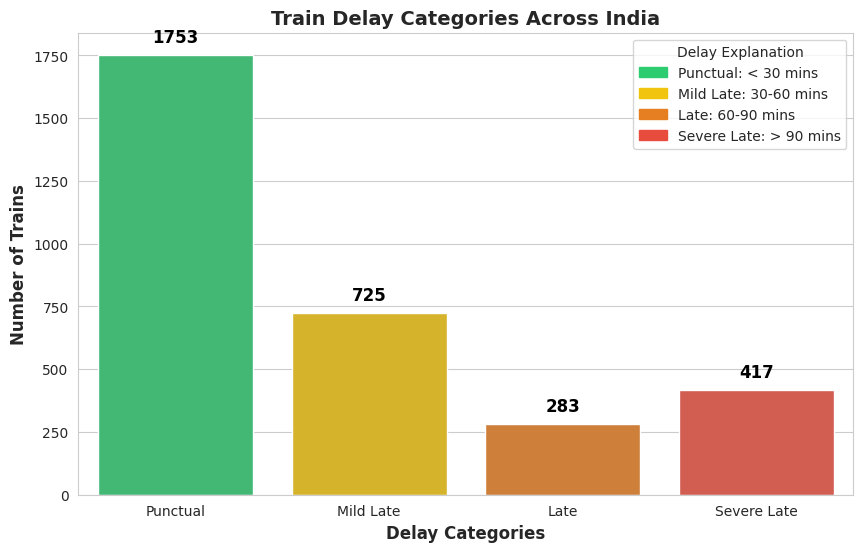

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data = pd.read_csv("train_data.csv")

# Calculate average and median delay
avg_late = np.mean(data["DelayOneMonth"])
median_late = np.median(data["DelayOneMonth"])

print(f"Average Late Of Trains Across India = {avg_late:.2f} minutes")
print(f"Median Late of Trains Across India = {median_late:.2f} minutes")

# Define categories, colors, and bins
categories = ["Punctual", "Mild Late", "Late", "Severe Late"]
colors = ["#2ecc71", "#f1c40f", "#e67e22", "#e74c3c"]  # Green to Red Gradient
bins = [0, 30, 60, 90, float("inf")]
arr = np.histogram(data["DelayOneMonth"], bins=bins)[0]

# Set seaborn style
sns.set_style("whitegrid")

# Create a bar plot
plt.figure(figsize=(10, 6))
bars = sns.barplot(x=categories, y=arr, palette=colors)

# Labeling the plot
plt.xlabel("Delay Categories", fontsize=12, fontweight="bold")
plt.ylabel("Number of Trains", fontsize=12, fontweight="bold")
plt.title("Train Delay Categories Across India", fontsize=14, fontweight="bold")

# Show count values on top of bars
for i, val in enumerate(arr):
    plt.text(i, val + 50, str(val), ha='center', fontsize=12, fontweight='bold', color='black')

# Create a custom legend
legend_labels = [
    "Punctual: < 30 mins",
    "Mild Late: 30-60 mins",
    "Late: 60-90 mins",
    "Severe Late: > 90 mins"
]
handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(4)]
plt.legend(handles, legend_labels, title="Delay Explanation", loc="upper right", fontsize=10)

plt.show()


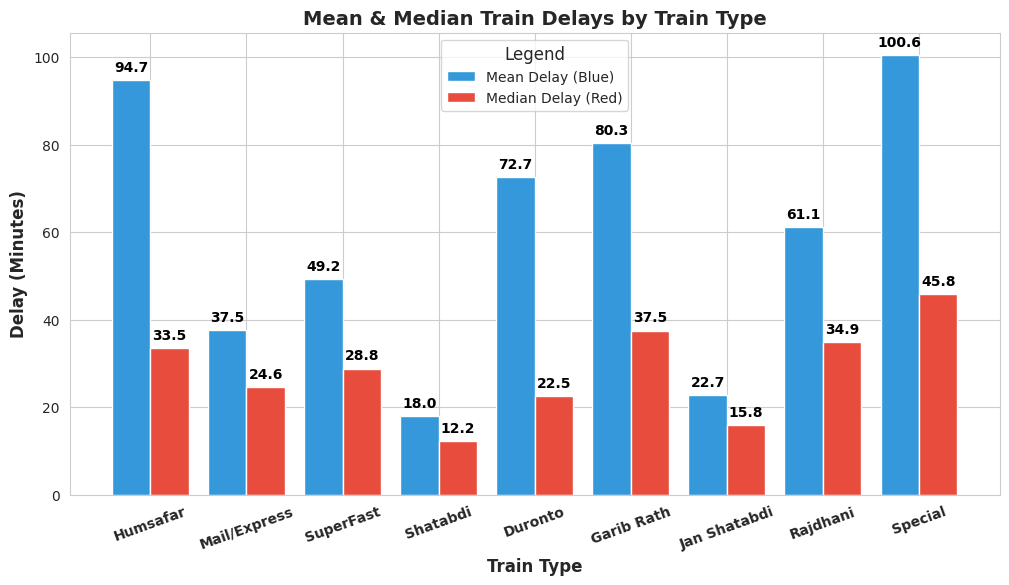

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data = pd.read_csv("train_data.csv")

# Define train categories
categories = ["HMS", "Mail", "SF", "SHT", "DUR", "GRB", "JSHT", "RJDN", "SPL"]
full_names = ["Humsafar", "Mail/Express", "SuperFast", "Shatabdi", "Duronto", "Garib Rath", "Jan Shatabdi", "Rajdhani", "Special"]

# Compute mean and median delays
mean_delay = data.groupby("TrainType")["DelayOneMonth"].mean()
median_delay = data.groupby("TrainType")["DelayOneMonth"].median()

# Set seaborn style
sns.set_style("whitegrid")

# Define colors
colors = ["#3498db", "#e74c3c"]  # Blue for mean, Red for median

# Set figure size
plt.figure(figsize=(12, 6))

# Bar width and x-axis positions
bar_width = 0.4
x = np.arange(len(categories))

# Plot bars
plt.bar(x - bar_width/2, mean_delay[categories], width=bar_width, label="Mean Delay (Blue)", color=colors[0])
plt.bar(x + bar_width/2, median_delay[categories], width=bar_width, label="Median Delay (Red)", color=colors[1])

# Labeling the plot
plt.xlabel("Train Type", fontsize=12, fontweight="bold")
plt.ylabel("Delay (Minutes)", fontsize=12, fontweight="bold")
plt.title("Mean & Median Train Delays by Train Type", fontsize=14, fontweight="bold")

# Custom x-axis labels
plt.xticks(ticks=x, labels=full_names, rotation=20, fontsize=10, fontweight="bold")

# Add value labels on bars
for i in range(len(categories)):
    plt.text(x[i] - bar_width/2, mean_delay[categories[i]] + 2, f"{mean_delay[categories[i]]:.1f}",
             ha='center', fontsize=10, fontweight="bold", color='black')
    plt.text(x[i] + bar_width/2, median_delay[categories[i]] + 2, f"{median_delay[categories[i]]:.1f}",
             ha='center', fontsize=10, fontweight="bold", color='black')

# Add legend with color labels
plt.legend(title="Legend", fontsize=10, title_fontsize=12)

# Show plot
plt.show()


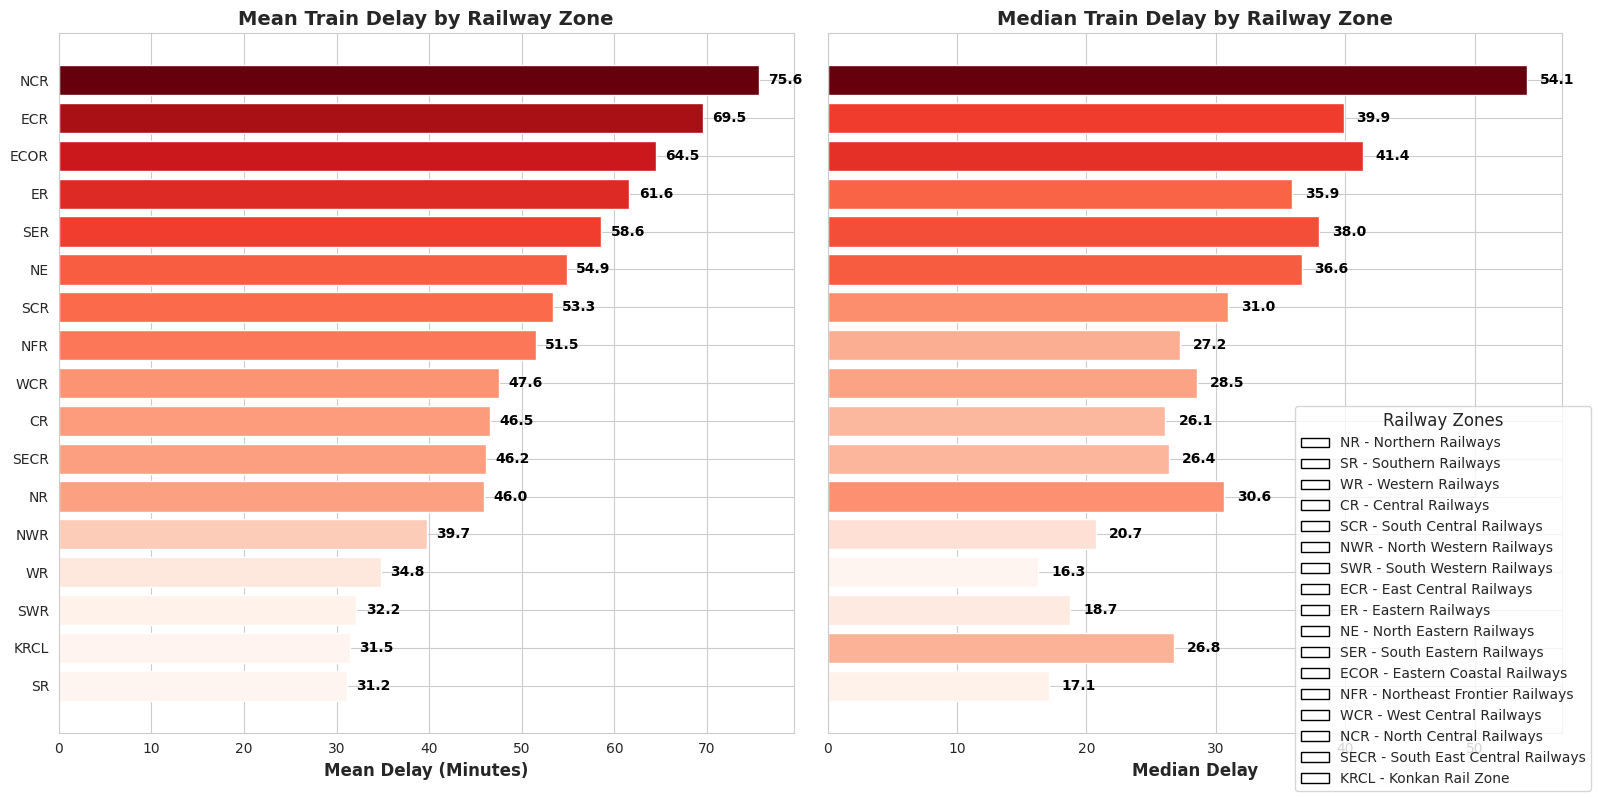

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data = pd.read_csv("train_data.csv")

# Get zone data
zone_data = data["DestinationZone"].value_counts()
zones = zone_data.index.tolist()

# Compute mean and median delays
mean_delay = data.groupby("DestinationZone")["DelayOneMonth"].mean()
median_delay = data.groupby("DestinationZone")["DelayOneMonth"].median()

# Define full names for railway zones
zone_labels = {
    "ECOR": "Eastern Coastal Railways",
    "NR": "Northern Railways",
    "NCR": "North Central Railways",
    "NE": "North Eastern Railways",
    "NWR": "North Western Railways",
    "WR": "Western Railways",
    "WCR": "West Central Railways",
    "CR": "Central Railways",
    "ECR": "East Central Railways",
    "ER": "Eastern Railways",
    "NFR": "Northeast Frontier Railways",
    "SER": "South Eastern Railways",
    "SECR": "South East Central Railways",
    "SR": "Southern Railways",
    "SCR": "South Central Railways",
    "SWR": "South Western Railways",
    "KRCL": "Konkan Rail Zone"
}

zone_labels = {z: zone_labels[z] for z in zones if z in zone_labels}

zones_sorted = mean_delay.sort_values().index.tolist()

sns.set_style("whitegrid")

norm_mean = plt.Normalize(mean_delay.min(), mean_delay.max())
norm_median = plt.Normalize(median_delay.min(), median_delay.max())

colors_mean = plt.cm.Reds(norm_mean(mean_delay[zones_sorted]))
colors_median = plt.cm.Reds(norm_median(median_delay[zones_sorted]))

fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)


axes[0].barh(zones_sorted, mean_delay[zones_sorted], color=colors_mean)
axes[0].set_xlabel("Mean Delay (Minutes)", fontsize=12, fontweight="bold")
axes[0].set_title("Mean Train Delay by Railway Zone", fontsize=14, fontweight="bold")


for i, zone in enumerate(zones_sorted):
    axes[0].text(mean_delay[zone] + 1, zone, f"{mean_delay[zone]:.1f}",
                 va='center', fontsize=10, fontweight="bold", color="black")


axes[1].barh(zones_sorted, median_delay[zones_sorted], color=colors_median)
axes[1].set_xlabel("Median Delay", fontsize=12, fontweight="bold")
axes[1].set_title("Median Train Delay by Railway Zone", fontsize=14, fontweight="bold")


for i, zone in enumerate(zones_sorted):
    axes[1].text(median_delay[zone] + 1, zone, f"{median_delay[zone]:.1f}",
                 va='center', fontsize=10, fontweight="bold", color="black")


legend_labels = [f"{abbr} - {zone_labels[abbr]}" for abbr in zone_labels]
handles = [plt.Rectangle((0,0),1,1, color="white", ec="black") for _ in zone_labels]
fig.legend(handles, legend_labels, title="Railway Zones", fontsize=10, title_fontsize=12, loc="lower right")

plt.tight_layout()
plt.show()

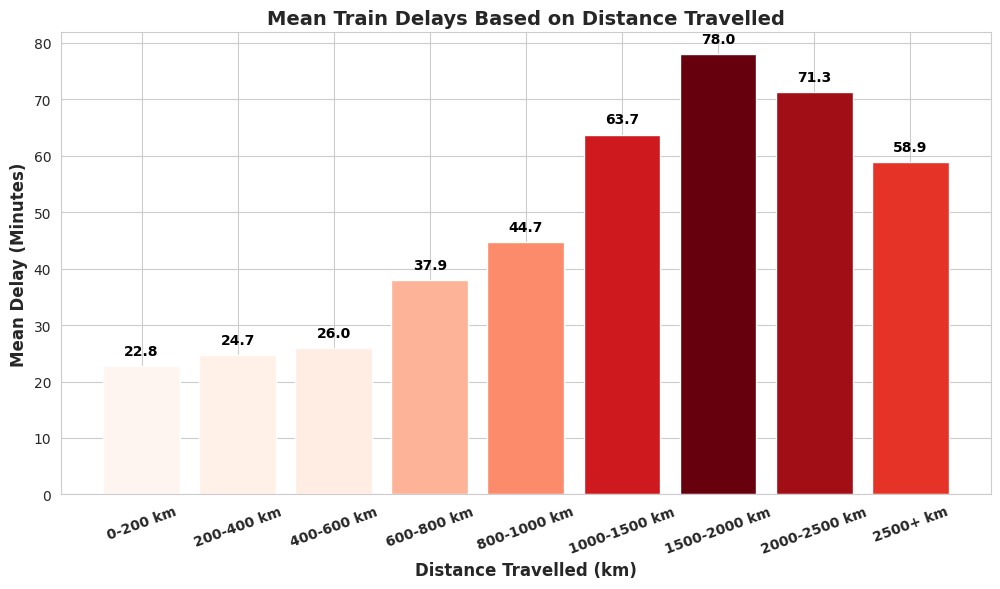

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("train_data.csv")

bins = [
    (0, 200), (200, 400), (400, 600), (600, 800), (800, 1000),
    (1000, 1500), (1500, 2000), (2000, 2500), (2500, np.inf)
]

labels = [
    "0-200 km", "200-400 km", "400-600 km", "600-800 km", "800-1000 km",
    "1000-1500 km", "1500-2000 km", "2000-2500 km", "2500+ km"
]


mean_delays = [data[(data["MaxDistance"] > low) & (data["MaxDistance"] <= high)]["DelayOneMonth"].mean() for low, high in bins]

sns.set_style("whitegrid")


norm = plt.Normalize(min(mean_delays), max(mean_delays))
colors = plt.cm.Reds(norm(mean_delays))

plt.figure(figsize=(12, 6))


bars = plt.bar(labels, mean_delays, color=colors)


plt.xlabel("Distance Travelled (km)", fontsize=12, fontweight="bold")
plt.ylabel("Mean Delay (Minutes)", fontsize=12, fontweight="bold")
plt.title("Mean Train Delays Based on Distance Travelled", fontsize=14, fontweight="bold")


plt.xticks(rotation=20, fontsize=10, fontweight="bold")


for bar, delay in zip(bars, mean_delays):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, f"{delay:.1f}",
             ha='center', fontsize=10, fontweight="bold", color='black')

plt.show()


In [ ]:
data.head()

data.drop(columns=["OriginZone", "DestinationZone","Origin","Destination","TrainType"], inplace=True)



<Axes: >

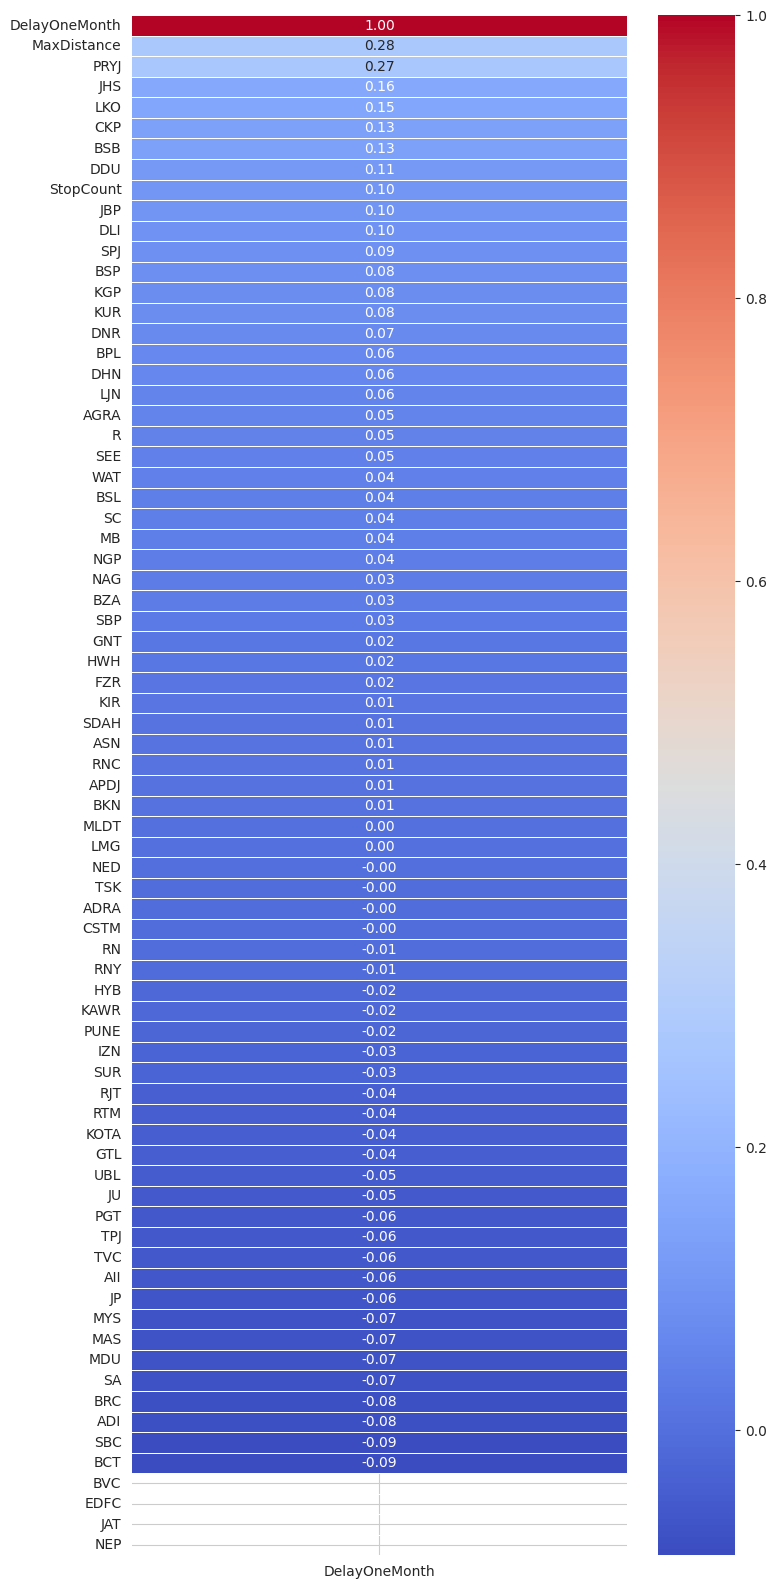

In [ ]:
correlation_matrix = data.corr()

delay_correlation = correlation_matrix[["DelayOneMonth"]].sort_values(by="DelayOneMonth", ascending=False)

plt.figure(figsize=(8,20))
sns.heatmap(delay_correlation, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f")

[0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96, 100, 104, 108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152, 156, 160, 164, 168, 172, 176, 180, 184, 188, 192, 196, 200, 204, 208, 212, 216, 220, 224, 228, 232, 236, 240, 244, 248, 252, 256, 260, 264, 268, 272, 276, 280, 284, 288, 292, 296, 300, 304, 308]
[0.009780125642490006, 0.010922330097087379, 0.023415191319246145, 0.02619931467732724, 0.025271273557966874, 0.01906053683609366, 0.01770416904625928, 0.014063392347230154, 0.010494003426613364, 0.009066247858366648, 0.00799543118218161, 0.005853797829811536, 0.006424900057110223, 0.004997144488863506, 0.004140491147915477, 0.0036407766990291263, 0.0038549400342661336, 0.0034266133637921186, 0.002569960022844089, 0.0024271844660194173, 0.002569960022844089, 0.0027841233580810964, 0.0019274700171330668, 0.0016419189034837236, 0.0018560822387207311, 0.002284408909194746, 0.001499143346659052, 0.0007852655625356939, 0.0018560822387

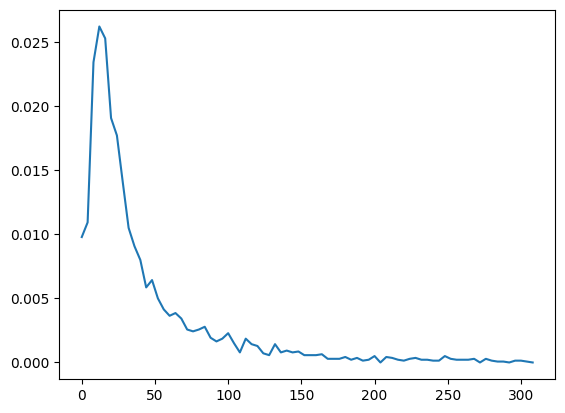

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

delayArray = np.sort(np.array(data["DelayOneMonth"]))

deltaX = 4
starting = 0
ending = 310

ptr1=0

pdf = []
range = []

while (ptr1<len(delayArray) and starting<=ending):
  ptr2=ptr1
  count=0
  while (ptr2<len(delayArray) and delayArray[ptr2]<=starting+deltaX):
    count+=1
    ptr2+=1
  probab = count/len(delayArray)
  pdf.append(probab/deltaX)
  range.append(starting)
  starting+=deltaX
  ptr1=ptr2

print(range)
print(pdf)

plt.plot(range,pdf)
plt.show()



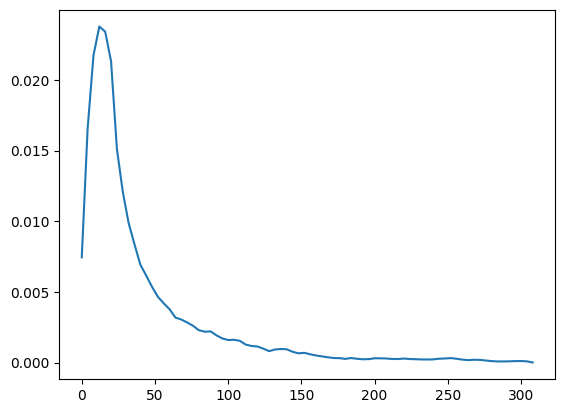

In [22]:
from scipy.signal import savgol_filter
pdf_smooth = savgol_filter(pdf, window_length=12, polyorder=4)
plt.plot(range,pdf_smooth)

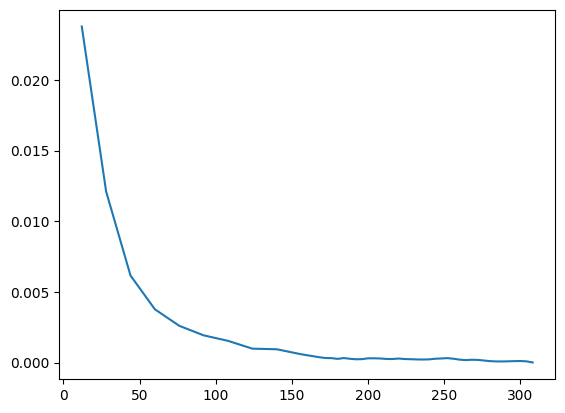

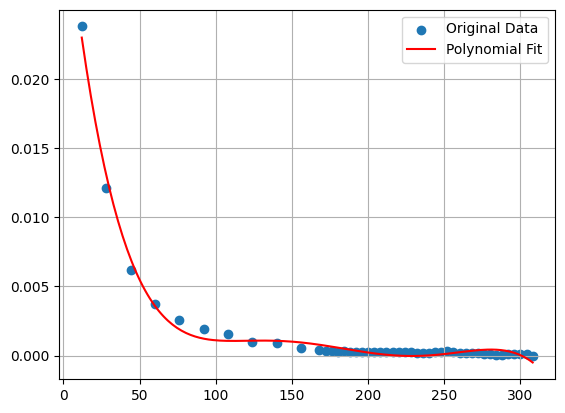

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

# Convert lists to numpy arrays and reshape for sklearn
X = np.array(range).reshape(-1, 1)  # Convert range list to 2D array
y = np.array(pdf_smooth)  # Convert pdf_smooth to array

# Create and fit the polynomial model
degree = 5
poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
poly_model.fit(X, y)

# Create smooth points for prediction
X_smooth = np.linspace(min(range), max(range), 200).reshape(-1, 1)
y_pred = poly_model.predict(X_smooth)

# Plot results
plt.scatter(range, pdf_smooth, label='Original Data')
plt.plot(X_smooth, y_pred, color='red', label='Polynomial Fit')
plt.legend()
plt.grid(True)
plt.show()

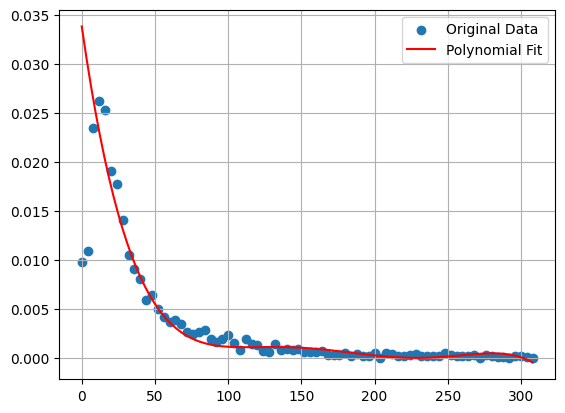

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

delayArray = np.sort(np.array(data["DelayOneMonth"]))

deltaX = 4
starting = 0
ending = 310

ptr1=0

pdf = []
range = []

while (ptr1<len(delayArray) and starting<=ending):
  ptr2=ptr1
  count=0
  while (ptr2<len(delayArray) and delayArray[ptr2]<=starting+deltaX):
    count+=1
    ptr2+=1
  probab = count/len(delayArray)
  pdf.append(probab/deltaX)
  range.append(starting)
  starting+=deltaX
  ptr1=ptr2


X_smooth = np.linspace(min(range), max(range), 200).reshape(-1, 1)
y_pred = poly_model.predict(X_smooth)

plt.scatter(range,pdf, label='Original Data')
plt.plot(X_smooth, y_pred, color='red', label='Polynomial Fit')
plt.legend()
plt.grid(True)
plt.show()

In [71]:
# Get the coefficients in descending order
coefficients = poly_model.named_steps['linearregression'].coef_[::-1]
intercept = poly_model.named_steps['linearregression'].intercept_

# Create a polynomial object
polynomial = np.poly1d(coefficients)
print(polynomial)


            5             4            3            2
-2.228e-13 x + 2.094e-10 x - 7.51e-08 x + 1.28e-05 x - 0.001043 x


In [78]:
from sklearn.metrics import r2_score

print(range)
print(pdf)


counter=0

while (counter<4):
  range.pop(0)
  pdf.pop(0)
  counter+=1

print(range)
print(pdf)
# Predict values for original X
X = np.array(range).reshape(-1, 1)
y_pred_train = poly_model.predict(X)




r2 = r2_score(pdf, y_pred_train)
print(f"R² Score: {r2:.4f}")


[0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96, 100, 104, 108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152, 156, 160, 164, 168, 172, 176, 180, 184, 188, 192, 196, 200, 204, 208, 212, 216, 220, 224, 228, 232, 236, 240, 244, 248, 252, 256, 260, 264, 268, 272, 276, 280, 284, 288, 292, 296, 300, 304, 308]
[0.009780125642490006, 0.010922330097087379, 0.023415191319246145, 0.02619931467732724, 0.025271273557966874, 0.01906053683609366, 0.01770416904625928, 0.014063392347230154, 0.010494003426613364, 0.009066247858366648, 0.00799543118218161, 0.005853797829811536, 0.006424900057110223, 0.004997144488863506, 0.004140491147915477, 0.0036407766990291263, 0.0038549400342661336, 0.0034266133637921186, 0.002569960022844089, 0.0024271844660194173, 0.002569960022844089, 0.0027841233580810964, 0.0019274700171330668, 0.0016419189034837236, 0.0018560822387207311, 0.002284408909194746, 0.001499143346659052, 0.0007852655625356939, 0.0018560822387